In [1]:
%load_ext lab_black

In [2]:
import timeit
import multiprocessing
from random import randint

import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def factors(a_int):
    """Find factors of an integer."""
    factors_list = []
    for i in range(1, a_int):
        if a_int % i == 0:
            factors_list.append(i)
    return factors_list

In [4]:
def single_thread(inputs, f):
    """
    Compute single threaded.
    """
    return [f(x) for x in inputs]


def multiprocess(inputs, f):
    """
    Compute multiprocess.
    """
    return Parallel(n_jobs=-1)(delayed(f)(x) for x in inputs)


def batch_multiprocess(inputs, f):
    """
    Compute multiprocess with one batch per process.
    """
    len_inputs = len(inputs)
    n_batches = multiprocessing.cpu_count()
    batch_size = len_inputs // n_batches

    batches = []
    for i in range(n_batches):
        start = batch_size * i
        end = (i + 1) * batch_size if i != n_batches - 1 else len_inputs
        batch = inputs[start:end]
        batches.append(batch)

    return Parallel(n_jobs=-1)(delayed(single_thread)(batch, f) for batch in batches)

In [5]:
def plot_compexity_benchmark(complexities, scale=1000, n_trials=1, filepath=None):
    """Creates a plot of complexity versus time, with fixed scale.
    Scale is defined as the size of the inputs list.
    Complexity is defined as the largest possible integer in the inputs
    that could be passed to a purposely inefficient factors function.

    Args:
        complexities: the different largest possible integers to try.
        scale: the size of the inputs that will be processed in each trail.
        n_trials: the number of times a trail is repeated for benchmark accuracy.
        filepath: the path to save the plot.
    """

    single_thread_times = []
    multiprocess_times = []
    batch_multiprocess_times = []

    for complexity in complexities:

        inputs = [randint(1, complexity) for _ in range(scale)]

        single_thread_time = timeit.timeit(
            lambda: single_thread(inputs, factors), number=n_trials
        )
        multiprocess_time = timeit.timeit(
            lambda: multiprocess(inputs, factors), number=n_trials
        )
        batch_multiprocess_time = timeit.timeit(
            lambda: batch_multiprocess(inputs, factors), number=n_trials
        )

        single_thread_times.append(single_thread_time)
        multiprocess_times.append(multiprocess_time)
        batch_multiprocess_times.append(batch_multiprocess_time)

    plt.plot(complexities, single_thread_times, marker="o", label="Single Thread")
    plt.plot(complexities, multiprocess_times, marker="o", label="Multiprocess")
    plt.plot(
        complexities, batch_multiprocess_times, marker="o", label="Batch Multiprocess"
    )
    plt.legend(title="Concurrency Pattern")
    plt.xlabel("Complexity of Problem (Lagest Integer)")
    plt.ylabel("Time (s)")
    if filepath:
        plt.savefig(filepath)
    plt.title(f"Complexity on Time (Length of Inputs = {scale})")

    plt.show()

In [6]:
def plot_scale_benchmark(scales, complexity=1000, n_trials=1, filepath=None):
    """Creates a plot of scale versus time, with fixed complexity.
    Scale is defined as the size of the inputs list.
    Complexity is defined as the largest possible integer in the inputs
    that could be passed to a purposely inefficient factors function.

    Args:
        scales: the different numbers of inputs to try
        complexity: the largest possible integer.
        n_trials: the number of times a trail is repeated for benchmark accuracy.
        filepath: the path to save the plot.
    """

    single_thread_times = []
    multiprocess_times = []
    batch_multiprocess_times = []

    for scale in scales:

        inputs = [randint(1, complexity) for _ in range(scale)]

        single_thread_time = timeit.timeit(
            lambda: single_thread(inputs, factors), number=n_trials
        )
        multiprocess_time = timeit.timeit(
            lambda: multiprocess(inputs, factors), number=n_trials
        )
        batch_multiprocess_time = timeit.timeit(
            lambda: batch_multiprocess(inputs, factors), number=n_trials
        )

        single_thread_times.append(single_thread_time)
        multiprocess_times.append(multiprocess_time)
        batch_multiprocess_times.append(batch_multiprocess_time)

    plt.plot(scales, single_thread_times, marker="o", label="Single Thread")
    plt.plot(scales, multiprocess_times, marker="o", label="Multiprocess")
    plt.plot(scales, batch_multiprocess_times, marker="o", label="Batch Multiprocess")
    plt.legend(title="Concurrency Pattern")
    plt.xlabel("Scale of Problem (Length of Inputs)")
    plt.ylabel("Time (s)")
    if filepath:
        plt.savefig(filepath)
    plt.title(f"Scale on Time (Largest Integer = {complexity})")

    plt.show()

In [7]:
def plot_benchmarks(
    scales,
    complexities,
    n_trials=1,
    filepath=None,
):

    """Creates a plot of scale and complexity versus time.
    Scale is defined as the size of the inputs list.
    Complexity is defined as the largest possible integer in the inputs
    that could be passed to a purposely inefficient factors function.

    Args:
        scales: the different numbers of inputs to try
        complexities: the different largest possible integers to try.
        n_trials: the number of times a trail is repeated for benchmark accuracy.
        filepath: the path to save the plot.
    """

    single_thread_times = []
    multiprocess_times = []
    batch_multiprocess_times = []

    for complexity in complexities:
        single_thread_row = []
        multiprocess_row = []
        batch_multiprocess_row = []

        for scale in scales:
            inputs = [randint(1, complexity) for _ in range(scale)]

            single_thread_time = timeit.timeit(
                lambda: single_thread(inputs, factors), number=n_trials
            )
            multiprocess_time = timeit.timeit(
                lambda: multiprocess(inputs, factors), number=n_trials
            )
            batch_multiprocess_time = timeit.timeit(
                lambda: batch_multiprocess(inputs, factors), number=n_trials
            )

            single_thread_row.append(single_thread_time)
            multiprocess_row.append(multiprocess_time)
            batch_multiprocess_row.append(batch_multiprocess_time)

        single_thread_times.append(single_thread_row)
        multiprocess_times.append(multiprocess_row)
        batch_multiprocess_times.append(batch_multiprocess_row)

    single_thread_df = pd.DataFrame(
        data=single_thread_times, index=complexities, columns=scales
    ).sort_index(ascending=False)
    multiprocess_df = pd.DataFrame(
        data=multiprocess_times, index=complexities, columns=scales
    ).sort_index(ascending=False)
    batch_multiprocess_df = pd.DataFrame(
        data=batch_multiprocess_times, index=complexities, columns=scales
    ).sort_index(ascending=False)

    max_time = max(
        [
            single_thread_df.max().max(),
            multiprocess_df.max().max(),
            batch_multiprocess_df.max().max(),
        ]
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 10))

    sns.heatmap(single_thread_df, cmap="Reds", vmin=0, vmax=max_time, ax=axes[0])
    sns.heatmap(multiprocess_df, cmap="Reds", vmin=0, vmax=max_time, ax=axes[1])
    sns.heatmap(batch_multiprocess_df, cmap="Reds", vmin=0, vmax=max_time, ax=axes[2])

    fig.suptitle("Scale and Complexity on Time", fontsize=20)
    fig.patch.set_facecolor("#FFFFFF")

    axes[0].set_title("Single Thread")
    axes[1].set_title("Multiprocess")
    axes[2].set_title("Batch Multiprocess")

    fig.supylabel("Complexity", fontsize=16)
    fig.supxlabel("Scale", fontsize=16)

    if filepath:
        plt.savefig(filepath)
    plt.show()

In [8]:
plt.rcParams["figure.facecolor"] = "#FFFFFF"

In [9]:
COMPLEXITIES = [100, 500, 1000, 1500, 2000]
SCALES = range(1_000, 10_000 + 1, 1_000)

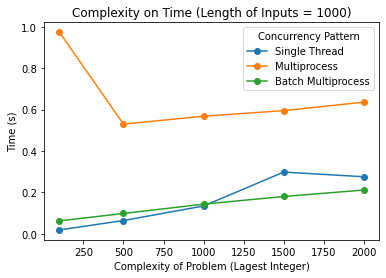

In [10]:
plot_compexity_benchmark(COMPLEXITIES, scale=1000, n_trials=5)

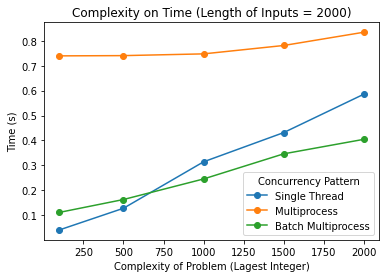

In [11]:
plot_compexity_benchmark(COMPLEXITIES, scale=2000, n_trials=5)

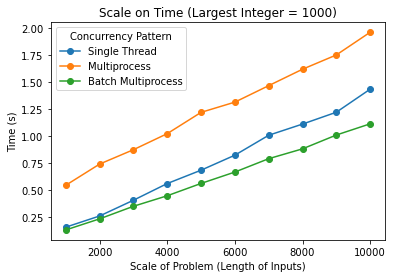

In [12]:
plot_scale_benchmark(SCALES, complexity=1000, n_trials=5)

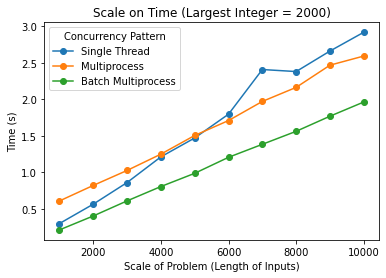

In [13]:
plot_scale_benchmark(SCALES, complexity=2000, n_trials=5)

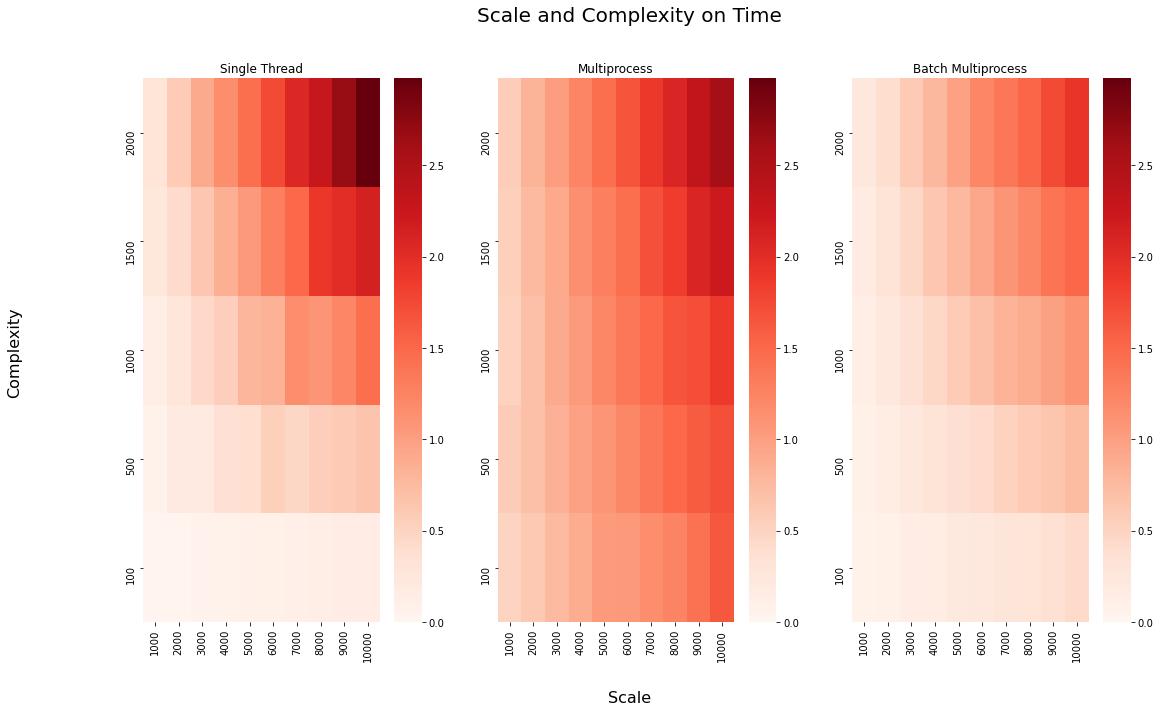

In [14]:
plot_benchmarks(SCALES, COMPLEXITIES, n_trials=5)